In [1]:
import re
import os
import sys
import inspect
import pandas as pd
os.chdir("..")
from src.info_extactor import InfoExtractor
print(os.getcwd())

/home/erezsc/PycharmProjects/geocore


In [2]:
# constants
#DATA_PATH = os.path.join("data","test.csv")
DATA_PATH = os.path.join("data","EPI_CoronaExposure_XRM_NEW_31_3_1807_TableToExcel_results.csv")

# field types
EXTRACTOR_CITY = "extractor_city"
EXTRACTOR_TYPE = "extractor_place_type"
GOOGLE_LOCATION_TYPE = "gmapapi_location_types"
GOOGLE_LOCATION_LEVEL = "gmapapi_location_type"
VALID = "valid"

In [3]:
df = pd.read_csv(DATA_PATH, index_col=0)
if "מקום" in df.columns.tolist():
    df.rename(columns={"מקום":"place"}, inplace=True)
df_topics = df[["place"]].astype("str")
os.chdir("src")
ie = InfoExtractor()

#gmapapi_location_type

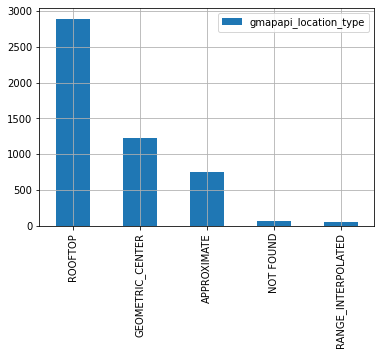

In [4]:
df[GOOGLE_LOCATION_LEVEL].fillna("NOT FOUND", inplace=True)
df[[GOOGLE_LOCATION_LEVEL]].apply(pd.value_counts).plot.bar(grid=True)

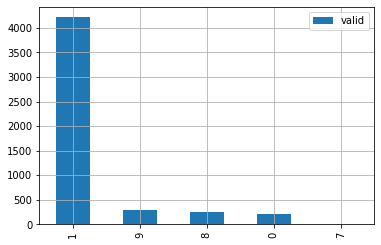

In [5]:
df[[VALID]].apply(pd.value_counts).plot.bar(grid=True)

Not valid google location level distribution


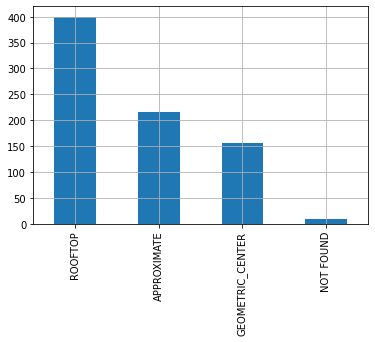

In [6]:
print("Not valid google location level distribution")
df[df[VALID] != 1][GOOGLE_LOCATION_LEVEL].apply(pd.value_counts).count().plot.bar(grid=True)

not rooftop and not valid location type distribution


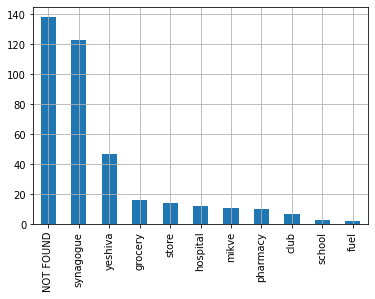

In [7]:
print("not rooftop and not valid location type distribution")
google_failed_df = df[(df[GOOGLE_LOCATION_LEVEL] != "ROOFTOP") & (df[VALID] != 1)]
google_failed_df[EXTRACTOR_TYPE].fillna("NOT FOUND").apply(pd.value_counts).count().sort_values(ascending=False).plot.bar(grid=True)

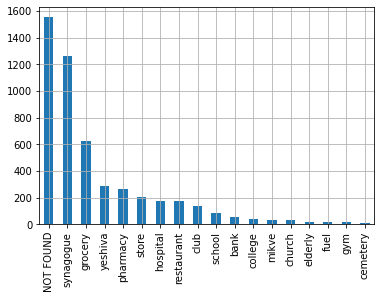

In [8]:
df[EXTRACTOR_TYPE].fillna("NOT FOUND").apply(pd.value_counts).count().sort_values(ascending=False).plot.bar(grid=True)

In [9]:
print("types that google does not miss: ")
set(df[EXTRACTOR_TYPE].fillna("NOT FOUND").values.tolist()).difference(set(google_failed_df[EXTRACTOR_TYPE].fillna("NOT FOUND").values.tolist()))

types that google does not miss: 


{'bank', 'cemetery', 'church', 'college', 'elderly', 'gym', 'restaurant'}

In [10]:
"percentage of Google extracted location types: {:.2f}".format(len(df[GOOGLE_LOCATION_TYPE].dropna()) / len(df["geostatusname"]))

'percentage of Google extracted location types: 0.99'

In [11]:
google_failed_df[["place", GOOGLE_LOCATION_LEVEL, GOOGLE_LOCATION_TYPE, EXTRACTOR_CITY, EXTRACTOR_TYPE]].to_csv("google_failed.csv")

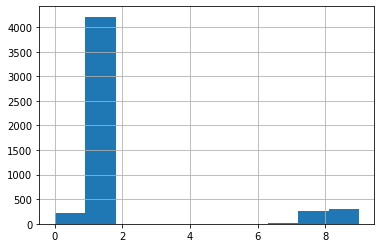

In [12]:
df["valid"].hist(bins=10)

In [13]:
"percentage of Google extracted cities: {:.2f}".format(len(df["CityName"].dropna()) / len(df["CityName"]))

'percentage of Google extracted cities: 0.53'

In [14]:
df_text = df["place"].astype("str")

In [15]:
df_topics["type"] = df_topics["place"].apply(lambda x: None if ie.extract_type(x) is None else ie.extract_type(x)[0])
df_topics["city"] = df_topics["place"].apply(ie.extract_city)
df_topics["city"] = df_topics["city"].apply(lambda x: None if x == '   ' else x)
df_topics["google_type"] = df["geostatusname"]
df_topics["google_city"] = df["CityName"]

In [16]:
df_topics.head()

,place,type,city,google_type,google_city
0,nan,None,None,NaN,NaN
1,nan,None,None,NaN,NaN
2,nan,None,None,NaN,NaN
3,תחנת אוטובוס דיזינגוף/פרישמן תל אביב,None,תל אביב,NaN,NaN
4,תחנת אוטובוס אלנבי (שוק הכרמל) תל אביב,None,תל אביב,NaN,NaN


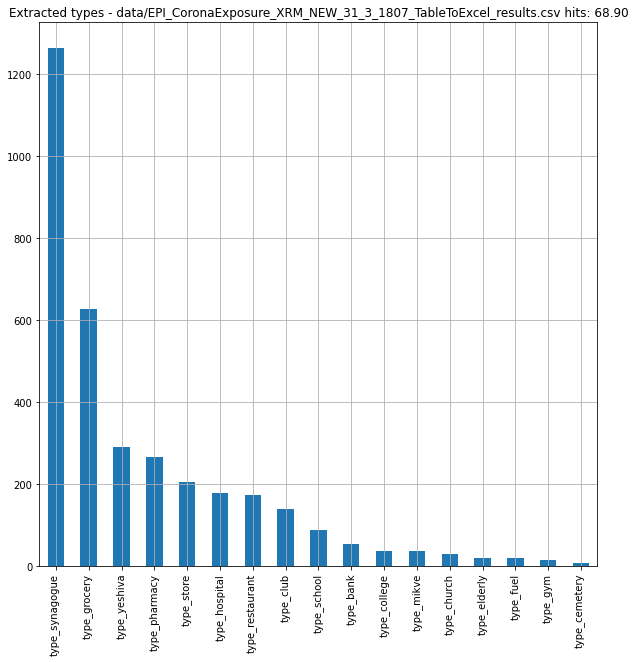

In [17]:
types_agg_df = pd.get_dummies(df_topics[["type"]]).agg("sum").sort_values(ascending=False)
total_extracted_types = types_agg_df.sum()
hit_percentage = "{:.2f}".format(total_extracted_types / len(df_topics) * 100)
types_agg_df.plot.bar(grid=True, figsize=(10,10), title="Extracted types - " + DATA_PATH + " hits: " + hit_percentage)

In [18]:
len(df_topics["city"].dropna()) / len(df_topics["city"])

0.8953162530024019

In [34]:
google_failed_df[google_failed_df[EXTRACTOR_TYPE] == "synagogue"]["place"]

871                     ביה"כנ הרי"ף - אשדוד
975           בית הכנסת ניסי ניסים - בני ברק
1120            בית כנסת אוסידון - מגדל העמק
1158               בית הכנסת פאר ששון - חדרה
1406       בית כנסת  "חסידי ביאלא" - ירושלים
                        ...                 
4975          בית הכנסת "שבט אחים" - באר שבע
4976        בית הכנסת "חסד לאברהם" - באר שבע
4977     בית כנסת "שבט אחוות אחים" - באר שבע
4985            בית הכנסת יד אהרון - בני ברק
4994    בית כנסת "יהושע דוד" - מודיעין עילית
Name: place, Length: 123, dtype: object

In [20]:
print("we miss type and google hits / our misses: {:.2f}".format(len(df_topics[df_topics["type"].isna() & ~df_topics["google_type"].isna()]) / len(df_topics[df_topics["type"].isna()])))
print("we miss city and google hits / our misses: {:.2f}".format(len(df_topics[df_topics["city"].isna() & ~df_topics["google_city"].isna()]) / len(df_topics[df_topics["city"].isna()])))

print("we hit type and google misses / google misses: {:.2f}".format(len(df_topics[~df_topics["type"].isna() & df_topics["google_type"].isna()]) / len(df_topics[df_topics["google_type"].isna()])))
print("we hit city and google misses / google misses: {:.2f}".format(len(df_topics[~df_topics["city"].isna() & df_topics["google_city"].isna()]) / len(df_topics[df_topics["google_city"].isna()])))

print("we miss city and google misses city / total: {:.2f}".format(len(df_topics[~(df_topics["city"].isna() | df_topics["google_city"].isna())]) / len(df_topics)))
print("we miss type and google misses type / total: {:.2f}".format(len(df_topics[~(df_topics["type"].isna() | df_topics["google_type"].isna())]) / len(df_topics)))

we miss type and google hits / our misses: 0.53
we miss city and google hits / our misses: 0.14
we hit type and google misses / google misses: 0.70
we hit city and google misses / google misses: 0.81
we miss city and google misses city / total: 0.52
we miss type and google misses type / total: 0.35


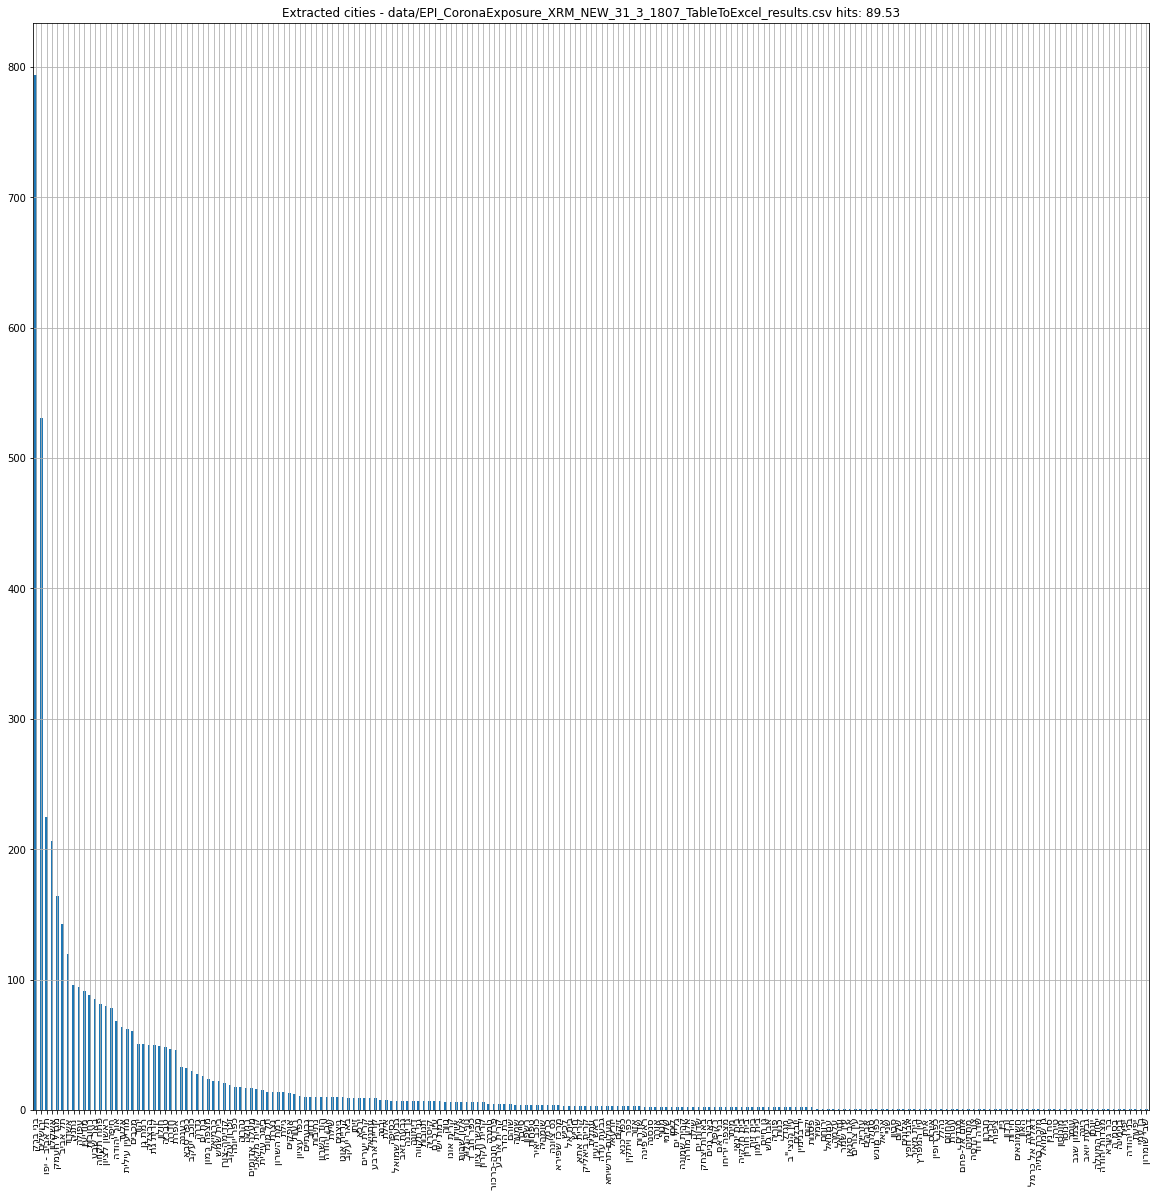

In [21]:
cities_agg_df = pd.get_dummies(df_topics[["city"]]).agg("sum").sort_values(ascending=False)
total_extracted_types = cities_agg_df.sum()
hit_percentage = "{:.2f}".format(total_extracted_types / len(df_topics) * 100)
cities_agg_df.index = pd.Series([x[5:][::-1] for x in cities_agg_df.index.tolist()])
cities_agg_df.plot.bar(grid=True, figsize=(20,20), title="Extracted cities - " + DATA_PATH + " hits: " + hit_percentage)

In [22]:
df_topics[df_topics["city"].isna()].head(100) #failed cities extraction

,place,type,city,google_type,google_city
0,nan,None,None,NaN,NaN
1,nan,None,None,NaN,NaN
2,nan,None,None,NaN,NaN
5,תחנת רכבת תל אביב-סבידור מרכז,None,None,NaN,NaN
7,תחנת רכבת תל אביב-סבידור מרכז,None,None,NaN,NaN
...,...,...,...,...,...
218,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN
219,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN
220,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN
221,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN


In [23]:
df_topics[df_topics["type"].isna()].head(100)  #failed type extraction

,place,type,city,google_type,google_city
0,nan,None,None,NaN,NaN
1,nan,None,None,NaN,NaN
2,nan,None,None,NaN,NaN
3,תחנת אוטובוס דיזינגוף/פרישמן תל אביב,None,תל אביב,NaN,NaN
4,תחנת אוטובוס אלנבי (שוק הכרמל) תל אביב,None,תל אביב,NaN,NaN
...,...,...,...,...,...
146,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN
147,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN
148,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN
149,קו 59 מאור יהודה (היסמין / החצב) לתל אביב (מנח...,None,None,NaN,NaN


In [ ]:
df[["USG_SP_NAM", "E_ORD","N_ORD"]].dropna()[df["USG_SP_NAM"].dropna().str.contains("אוהל יעקב")]